In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "Virny":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /Users/denys_herasymuk/UCU/4course_2term/Bachelor_Thesis/Code/Virny


# Multiple Models Interface With PyTorch Tabular

In this example, we are going to conduct a performance profiling for 1 deep learning model from PyTorch Tabular. For that, we will use `compute_metrics_with_config` interface that can compute metrics for multiple models. Thus, we will need to do the next steps:

* Initialize input variables

* Compute subgroup metrics

* Perform disparity metrics composition using the Metric Composer

* Create static visualizations using the Metric Visualizer

## Import dependencies

In [4]:
import os
from datetime import datetime, timezone

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from virny.datasets import DiabetesDataset2019
from virny.utils.custom_initializers import create_config_obj, read_model_metric_dfs
from virny.user_interfaces.multiple_models_api import compute_metrics_with_config
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.custom_classes.metrics_visualizer import MetricsVisualizer
from virny.custom_classes.metrics_composer import MetricsComposer

## Initialize Input Variables

Based on the library flow, we need to create 3 input objects for a user interface:

* A **config yaml** that is a file with configuration parameters for different user interfaces for metric computation.

* A **dataset class** that is a wrapper above the user’s raw dataset that includes its descriptive attributes like a target column, numerical columns, categorical columns, etc. This class must be inherited from the BaseDataset class, which was created for user convenience.

* Finally, a **models config** that is a Python dictionary, where keys are model names and values are initialized models for analysis. This dictionary helps conduct audits for different analysis modes and analyze different types of models.

In [5]:
DATASET_SPLIT_SEED = 42
MODELS_TUNING_SEED = 42
TEST_SET_FRACTION = 0.2

### Create a config object

`compute_metrics_with_config` interface requires that your **yaml file** includes the following parameters:

* **dataset_name**: str, a name of your dataset; it will be used to name files with metrics.

* **bootstrap_fraction**: float, the fraction from a train set in the range [0.0 - 1.0] to fit models in bootstrap (usually more than 0.5).

* **random_state**: int, a seed to control the randomness of the whole model evaluation pipeline.

* **n_estimators**: int, the number of estimators for bootstrap to compute subgroup stability metrics.

* **computation_mode**: str, 'default' or 'error_analysis'. Name of the computation mode. When a default computation mode measures metrics for sex_priv and sex_dis, an `error_analysis` mode measures metrics for (sex_priv, sex_priv_correct, sex_priv_incorrect) and (sex_dis, sex_dis_correct, sex_dis_incorrect). Therefore, a user can analyze how a model is certain about its incorrect predictions.

* **sensitive_attributes_dct**: dict, a dictionary where keys are sensitive attribute names (including intersectional attributes), and values are disadvantaged values for these attributes. Intersectional attributes must include '&' between sensitive attributes. You do not need to specify disadvantaged values for intersectional groups since they will be derived from disadvantaged values in sensitive_attributes_dct for each separate sensitive attribute in this intersectional pair.

Note that disadvantaged value in a sensitive attribute dictionary must be **the same as in the original dataset**. For example, when distinct values of the _sex_ column in the original dataset are 'F' and 'M', and after pre-processing they became 0 and 1 respectively, you still need to set a disadvantaged value as 'F' or 'M' in the sensitive attribute dictionary.

In [6]:
ROOT_DIR = os.path.join('docs', 'examples')
config_yaml_path = os.path.join(ROOT_DIR, 'experiment_config.yaml')
config_yaml_content = """
random_state: 42
dataset_name: diabetes
bootstrap_fraction: 0.8
n_estimators: 10  # Better to input the higher number of estimators than 100; this is only for this use case example
sensitive_attributes_dct: {'Gender': 'Female'}
"""

with open(config_yaml_path, 'w', encoding='utf-8') as f:
    f.write(config_yaml_content)

In [7]:
config = create_config_obj(config_yaml_path=config_yaml_path)
SAVE_RESULTS_DIR_PATH = os.path.join(ROOT_DIR, 'results', f'{config.dataset_name}_Metrics_{datetime.now(timezone.utc).strftime("%Y%m%d__%H%M%S")}')

### Preprocess the dataset and create a BaseFlowDataset class

Based on the BaseDataset class, your **dataset class** should include the following attributes:

* **Obligatory attributes**: dataset, target, features, numerical_columns, categorical_columns

* **Optional attributes**: X_data, y_data, columns_with_nulls

For more details, please refer to the library documentation.

In [8]:
data_loader = DiabetesDataset2019(with_nulls=False)
data_loader.X_data[data_loader.X_data.columns[:5]].head()

,BMI,Sleep,SoundSleep,Pregnancies,Age
0,39.0,8,6,0.0,50-59
1,28.0,8,6,0.0,50-59
2,24.0,6,6,0.0,40-49
3,23.0,8,6,0.0,50-59
4,27.0,8,8,0.0,40-49


In [9]:
column_transformer = ColumnTransformer(transformers=[
    ('categorical_features', OneHotEncoder(handle_unknown='ignore', sparse_output=False), data_loader.categorical_columns),
    ('numerical_features', StandardScaler(), data_loader.numerical_columns),
])

In [10]:
base_flow_dataset = preprocess_dataset(data_loader=data_loader,
                                       column_transformer=column_transformer,
                                       sensitive_attributes_dct=config.sensitive_attributes_dct,
                                       test_set_fraction=TEST_SET_FRACTION,
                                       dataset_split_seed=DATASET_SPLIT_SEED)

### Create a models config for metrics computation

**models_config** is a Python dictionary, where keys are model names and values are initialized models for analysis

In [11]:
from pytorch_tabular.models import GANDALFConfig
from pytorch_tabular import TabularModel
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
)

data_config = DataConfig(
    target=[
        data_loader.target
    ],  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=[col for col in base_flow_dataset.X_train_val.columns if col.startswith('numerical_')],
    categorical_cols=[col for col in base_flow_dataset.X_train_val.columns if col.startswith('categorical_')],
)
trainer_config = TrainerConfig(
    batch_size=512,
    max_epochs=10,
    load_best=False,
    trainer_kwargs=dict(enable_model_summary=False, # Turning off model summary
                        log_every_n_steps=None,
                        enable_progress_bar=False),
)
optimizer_config = OptimizerConfig()
model_config = GANDALFConfig(
    task="classification",
    gflu_stages=6,
    gflu_feature_init_sparsity=0.3,
    gflu_dropout=0.0,
    learning_rate=1e-3,
)

In [12]:
models_config = {
    'GANDALFClassifier': TabularModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        verbose=False,
        suppress_lightning_logger=True,
    ),
}

## Subgroup Metric Computation

After that we need to input the _BaseFlowDataset_ object, models config, and config yaml to a metric computation interface and execute it. The interface uses subgroup analyzers to compute different sets of metrics for each privileged and disadvantaged group. As for now, our library supports **Subgroup Variance Analyzer** and **Subgroup Error Analyzer**, but it is easily extensible to any other analyzers. When the variance and error analyzers complete metric computation, their metrics are combined, returned in a matrix format, and stored in a file if defined.

In [13]:
metrics_dct = compute_metrics_with_config(base_flow_dataset, config, models_config, SAVE_RESULTS_DIR_PATH, notebook_logs_stdout=True)

Analyze multiple models:   0%|          | 0/1 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/10 [00:00<?, ?it/s]

Look at several columns in top rows of computed metrics. Note that now we have metrics also for `*_correct` and `*_incorrect` subgroups.

In [14]:
sample_model_metrics_df = metrics_dct[list(models_config.keys())[0]]
sample_model_metrics_df[sample_model_metrics_df.columns[:5]].head(20)

,Metric,overall,Gender_priv,Gender_dis,Model_Name
0,Statistical_Bias,0.295597,0.321831,0.248779,GANDALFClassifier
1,Mean_Prediction,0.738774,0.752824,0.713700,GANDALFClassifier
2,Std,0.086163,0.084164,0.089730,GANDALFClassifier
3,Aleatoric_Uncertainty,0.690577,0.690398,0.690896,GANDALFClassifier
4,IQR,0.105706,0.105639,0.105825,GANDALFClassifier
5,Overall_Uncertainty,0.722770,0.720565,0.726706,GANDALFClassifier
6,Epistemic_Uncertainty,0.032193,0.030167,0.035810,GANDALFClassifier
7,Jitter,0.104850,0.100192,0.113162,GANDALFClassifier
8,Label_Stability,0.851934,0.860345,0.836923,GANDALFClassifier
9,TPR,0.326531,0.212121,0.562500,GANDALFClassifier


## Disparity Metric Composition

To compose disparity metrics, the Metric Composer should be applied. **Metric Composer** is responsible for the second stage of the model audit. Currently, it computes our custom error disparity, stability disparity, and uncertainty disparity metrics, but extending it for new disparity metrics is very simple. We noticed that more and more disparity metrics have appeared during the last decade, but most of them are based on the same group specific metrics. Hence, such a separation of group specific and disparity metrics computation allows us to experiment with different combinations of group specific metrics and avoid group metrics recomputation for a new set of disparity metrics.

In [15]:
models_metrics_dct = read_model_metric_dfs(SAVE_RESULTS_DIR_PATH, model_names=list(models_config.keys()))

In [16]:
metrics_composer = MetricsComposer(models_metrics_dct, config.sensitive_attributes_dct)

Compute composed metrics

In [17]:
models_composed_metrics_df = metrics_composer.compose_metrics()

## Metric Visualization

**Metric Visualizer** allows us to build static visualizations for the computed metrics. It unifies different preprocessing methods for the computed metrics and creates various data formats required for visualizations. Hence, users can simply call methods of the MetricsVisualizer class and get custom plots for diverse metric analysis.

In [18]:
visualizer = MetricsVisualizer(models_metrics_dct, models_composed_metrics_df, config.dataset_name,
                               model_names=list(models_config.keys()),
                               sensitive_attributes_dct=config.sensitive_attributes_dct)

In [19]:
visualizer.create_overall_metrics_bar_char(
    metric_names=['Accuracy', 'F1', 'TPR', 'TNR', 'PPV', 'Selection-Rate'],
    plot_title="Accuracy Metrics"
)

alt.Chart(...)

In [20]:
visualizer.create_overall_metrics_bar_char(
    metric_names=['Aleatoric_Uncertainty', 'Overall_Uncertainty', 'Label_Stability', 'Std', 'IQR', 'Jitter'],
    plot_title="Stability and Uncertainty Metrics"
)

alt.Chart(...)

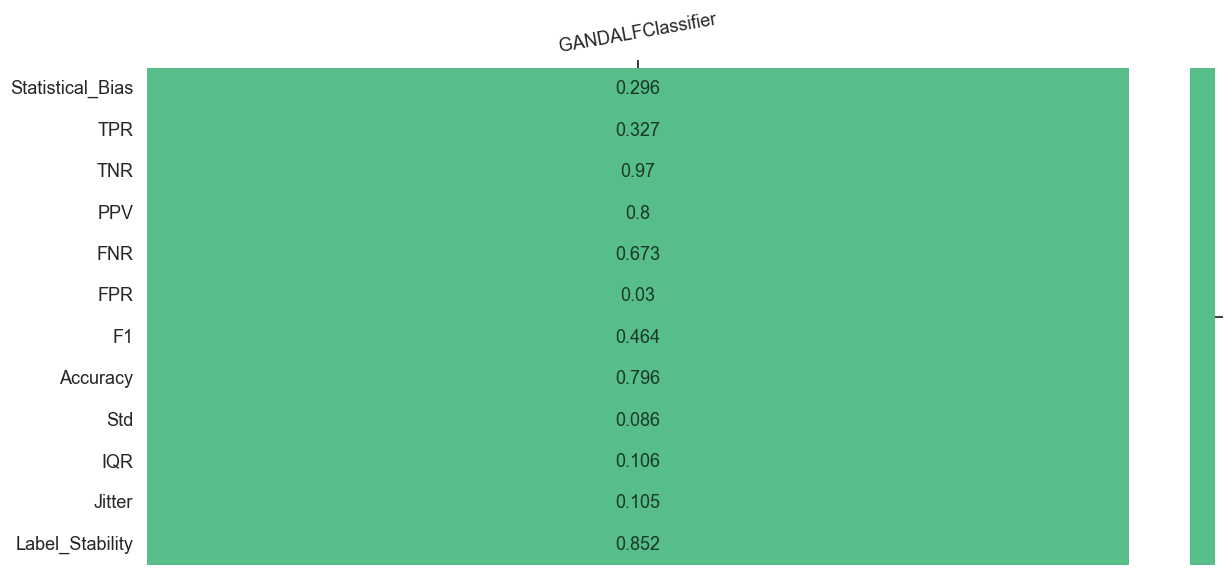

In [21]:
visualizer.create_overall_metric_heatmap(
    model_names=list(models_metrics_dct.keys()),
    metrics_lst=visualizer.all_accuracy_metrics + visualizer.all_stability_metrics,
    tolerance=0.005,
)

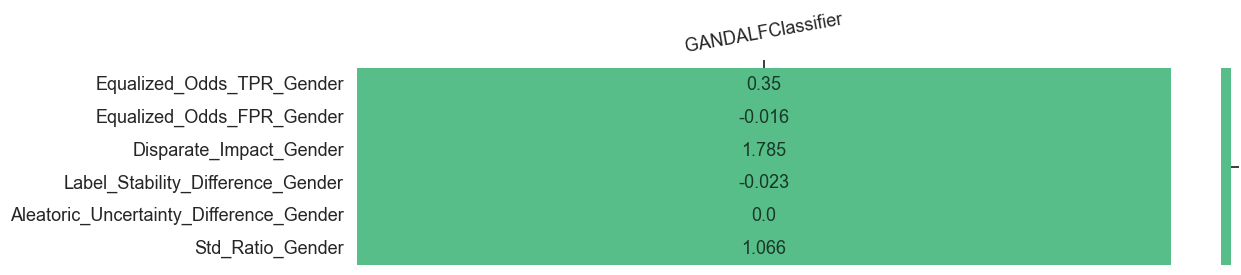

In [22]:
visualizer.create_disparity_metric_heatmap(
    model_names=list(models_metrics_dct.keys()),
    metrics_lst=[
        # Error disparity metrics
        'Equalized_Odds_TPR',
        'Equalized_Odds_FPR',
        'Disparate_Impact',
        # Stability disparity metrics
        'Label_Stability_Difference',
        'Aleatoric_Uncertainty_Difference',
        'Std_Ratio',
    ],
    groups_lst=config.sensitive_attributes_dct.keys(),
    tolerance=0.005,
)